# Arizona Coyotes - Venue Relocation
* StelllarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* Mar 11, 2022

## Hypothesis
With the Coyotes undergoing a venue relocation, we think that the distToVenue feature could have a significant impact on package buyers. This notebook will measure the importance of the distToVenue (distance to venue) feature according to the SA product propensity model

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [6]:
import getpass
import pyodbc
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from pycaret.classification import *

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Define the global variables used in this notebook:

In [7]:
DB_NAME = "stlrCoyotes"
LKUPCLIENTID = 55
PRODUCT = "Individual"

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [8]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password ··················


In [9]:
cursor = CNXN.cursor()

storedProc = (
    f"""Exec {DB_NAME}.[ds].[PropensityEventTraining] {LKUPCLIENTID}"""
)

df = pd.read_sql(storedProc, CNXN)
    
CNXN.commit()
cursor.close()

df.shape

(128836, 17)

In [12]:
df.head()

,daysOut,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,eventDate,eventName,inMarket,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,count_merchOwned
0,1 to 3 Days Out,1,4.0,226,0.0,0.0,2019-02-28,20190228 - Vancouver Canucks,False,2942.73,517,1,73,0.0,0.000000,0.014493,0
1,1 to 3 Days Out,1,4.0,569,0.0,0.0,2020-04-02,20200402 - Vancouver Canucks,True,7.82,859,0,114,0.0,0.000000,0.009524,0
2,1 to 3 Days Out,1,4.0,587,0.0,0.0,2021-12-10,20211210 - Florida Panthers,False,592.63,1883,0,182,0.0,0.076923,0.005848,0
3,1 to 3 Days Out,1,4.0,666,0.0,0.0,2018-01-12,20180112 - Edmonton Oilers,False,246.42,853,0,107,0.0,0.000000,0.028302,0
4,1 to 3 Days Out,1,4.0,706,0.0,0.0,2017-12-22,20171222 - Washington Capitals,True,20.61,77,0,15,0.0,0.000000,0.066667,0


### Let's specify the default SA features for our model:

In [13]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (109511, 17)
Unseen Data For Predictions: (19325, 17)



### Now we can model the data using a multiclass classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [18]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.85,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=[
        "count_merchOwned",
        "dimCustomerMasterId",
        "eventDate",
        "eventName",
        "minDaysOut",
        "maxDaysOut"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate",
        "tenure"
    ]
);

In [23]:
model_matrix = compare_models(
    fold=10,
    include=["lightgbm"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8059,0.8917,0.7872,0.8181,0.8023,0.6117,0.6122,0.8830


### Now that we have the best performing model, we can finalize it:

In [24]:
best_model = create_model(model_matrix)
final_model = finalize_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8021,0.8889,0.7871,0.8118,0.7993,0.6043,0.6045
1,0.8084,0.8930,0.7873,0.8222,0.8044,0.6167,0.6173
2,0.8046,0.8906,0.7821,0.8192,0.8003,0.6092,0.6098
3,0.8044,0.8939,0.7832,0.8182,0.8003,0.6088,0.6093
4,0.8047,0.8916,0.7892,0.8148,0.8018,0.6094,0.6097
5,0.8107,0.8957,0.8006,0.8174,0.8089,0.6214,0.6215
6,0.8035,0.8896,0.7789,0.8196,0.7987,0.6070,0.6078
7,0.8018,0.8870,0.7839,0.8134,0.7983,0.6036,0.6040
8,0.8107,0.8936,0.7959,0.8205,0.8080,0.6214,0.6217
9,0.8078,0.8927,0.7836,0.8238,0.8032,0.6156,0.6164


### This plot lists the most important features for a correct prediction made by the model:

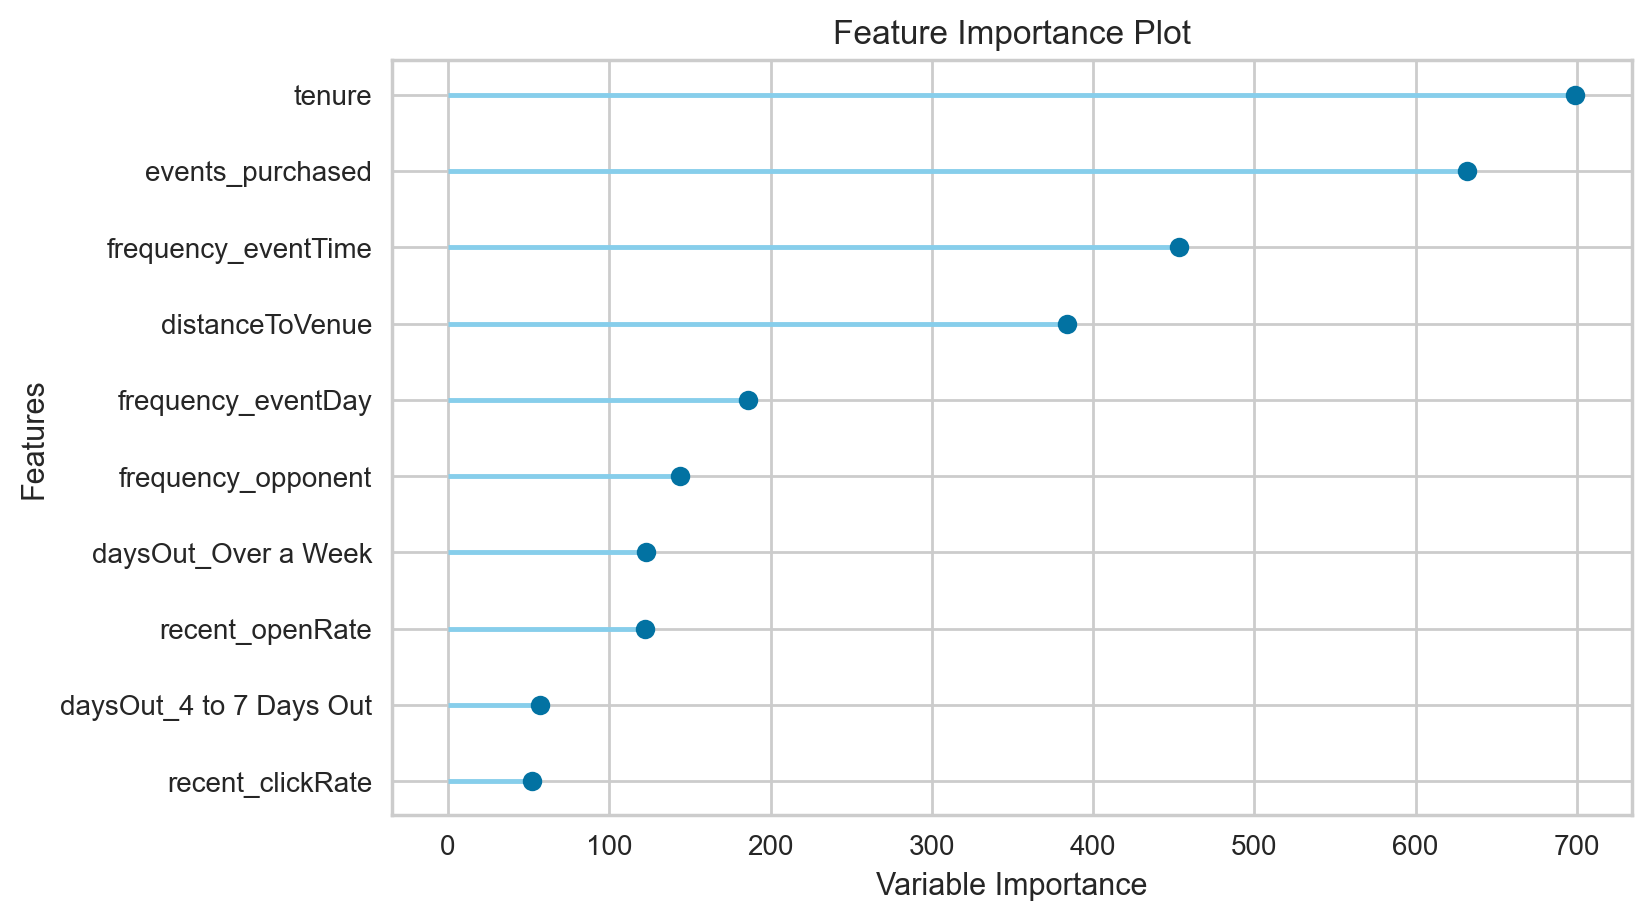

In [27]:
plot_model(final_model, plot='feature')

## Observations

* distanceToVenue ranks as the 4th most important feature and should be considered a significant variable when making a correct predicition on an individual ticket purchase.